<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Oscar Flores y Andres Hernández

**Fecha:** 4 de Mayo de 2021

**Expediente** : 715029 y 717895
**Profesor:** Oscar David Jaramillo Zuluaga.

**Link Github:** https://github.com/OscarFlores-IFi/SPF-2021-Tareas

# Tarea 11: Clase 24
  

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

## Respuesta Oscar

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

Date
2017-01-03     58.538
2017-01-04     58.276
2017-01-05     58.276
2017-01-06     58.782
2017-01-09     58.595
               ...   
2021-04-29    252.510
2021-04-30    252.180
2021-05-03    251.860
2021-05-04    247.790
2021-05-05    246.470
Name: MSFT, Length: 1092, dtype: float64

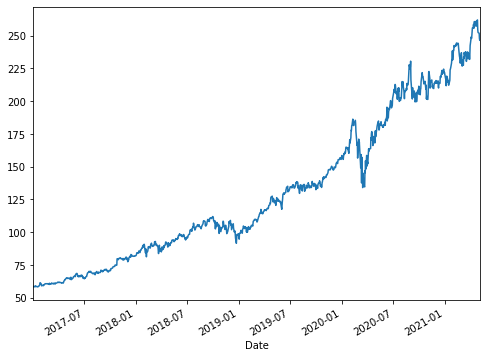

In [5]:
closes_msft.plot(figsize=(8,6));

In [6]:
closes_msft[-1]

246.47000122070312

## Calculamos rendimientos

In [7]:
ret_msft = calc_daily_ret(closes_msft)
ret_msft

Date
2017-01-04   -4.484e-03
2017-01-05    0.000e+00
2017-01-06    8.630e-03
2017-01-09   -3.188e-03
2017-01-10   -3.194e-04
                ...    
2021-04-29   -8.086e-03
2021-04-30   -1.308e-03
2021-05-03   -1.270e-03
2021-05-04   -1.629e-02
2021-05-05   -5.341e-03
Name: MSFT, Length: 1091, dtype: float64

## Descargamos datos de opciones para poder valuarlos


Descargamos datos de opciones

In [8]:
pd.set_option('display.max_rows', 10)

msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index()#.head(1000)

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2021-05-07,212.5,put,MSFT210507P00212500,...,2021-05-05 23:59:51,2021-05-05 16:18:42,"{'contractSymbol': 'MSFT210507P00212500', 'str..."
2021-05-07,310.0,call,MSFT210507C00310000,...,2021-05-05 23:59:51,2021-05-03 18:19:38,"{'contractSymbol': 'MSFT210507C00310000', 'str..."
2021-05-07,310.0,put,MSFT210507P00310000,...,2021-05-05 23:59:51,2021-05-04 18:22:27,"{'contractSymbol': 'MSFT210507P00310000', 'str..."
2021-05-07,235.0,call,MSFT210507C00235000,...,2021-05-05 23:59:51,2021-05-05 19:21:09,"{'contractSymbol': 'MSFT210507C00235000', 'str..."
2021-05-07,235.0,put,MSFT210507P00235000,...,2021-05-05 23:59:51,2021-05-05 19:41:51,"{'contractSymbol': 'MSFT210507P00235000', 'str..."
...,...,...,...,...,...,...,...
2023-06-16,120.0,put,MSFT230616P00120000,...,2021-05-05 23:59:51,2021-04-21 14:36:50,"{'contractSymbol': 'MSFT230616P00120000', 'str..."
2023-06-16,295.0,call,MSFT230616C00295000,...,2021-05-05 23:59:51,2021-05-05 17:11:28,"{'contractSymbol': 'MSFT230616C00295000', 'str..."
2023-06-16,295.0,put,MSFT230616P00295000,...,2021-05-05 23:59:51,2021-05-03 13:39:26,"{'contractSymbol': 'MSFT230616P00295000', 'str..."


Asumiendo que queremos la opcion para el 17 de Septiembre de 2021:

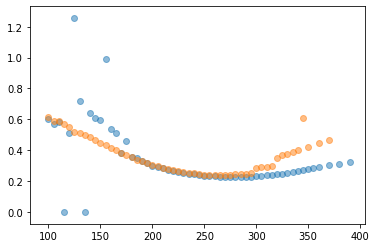

In [9]:
strike_call_msft = msft_opt['Strike'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'call')]
option_call_msft = msft_opt['IV'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'call')]
strike_put_msft = msft_opt['Strike'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'put')]
option_put_msft = msft_opt['IV'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'put')]


plt.scatter(strike_call_msft, option_call_msft, alpha = 0.5);
plt.scatter(strike_put_msft, option_put_msft, alpha = 0.5);

Debido a que son bastante similares la mayoría de los precios de opciones para esa fecha, tomaremos 280 como el valor de strike (K). 

In [10]:
opt_deseada = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Strike==280) & (msft_opt.Expiry=='2021-09-17')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1305,280.0,2021-09-17,call,...,2021-05-05 23:59:51,2021-05-05 18:36:29,"{'contractSymbol': 'MSFT210917C00280000', 'str..."


In [11]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            280
Expiry                                            2021-09-17 00:00:00
Type                                                             call
Symbol                                            MSFT210917C00280000
Last                                                             3.25
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  246
Quote_Time                                        2021-05-05 23:59:51
Last_Trade_Date                                   2021-05-05 18:36:29
JSON                {'contractSymbol': 'MSFT210917C00280000', 'str...
Name: 1305, Length: 19, dtype: object

Información de la opción

In [12]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT210917C00280000',
 'strike': 280.0,
 'currency': 'USD',
 'lastPrice': 3.25,
 'change': -0.45000005,
 'percentChange': -12.162163,
 'volume': 23,
 'openInterest': 9330,
 'bid': 3.1,
 'ask': 3.3,
 'contractSize': 'REGULAR',
 'expiration': 1631836800,
 'lastTradeDate': 1620239789,
 'impliedVolatility': 0.22260298889160152,
 'inTheMoney': False}

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [13]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.006/360
mu, sigma, r

(0.0013176508099668406, 0.017983725313409405, 1.6666666666666667e-05)

### Simulación de precios

In [14]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+mu,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

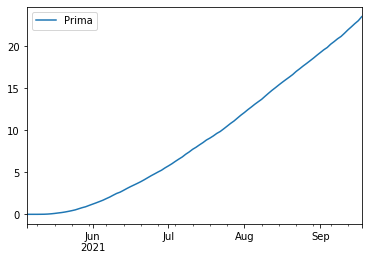

In [15]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [16]:
call.iloc[-1]

Prima    23.521
Name: 2021-09-17 00:00:00, dtype: float64

### Intervarlos de confianza

In [17]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(22.49881615925231, 24.543825188057195)


In [18]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT210917C00280000',
 'strike': 280.0,
 'currency': 'USD',
 'lastPrice': 3.25,
 'change': -0.45000005,
 'percentChange': -12.162163,
 'volume': 23,
 'openInterest': 9330,
 'bid': 3.1,
 'ask': 3.3,
 'contractSize': 'REGULAR',
 'expiration': 1631836800,
 'lastTradeDate': 1620239789,
 'impliedVolatility': 0.22260298889160152,
 'inTheMoney': False}

### 1.2 Histograma de rendimientos

In [19]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [20]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

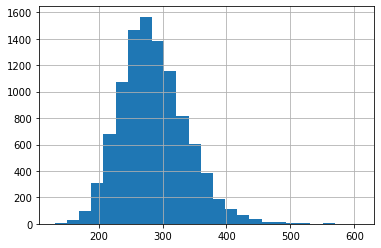

In [21]:
sim_closes_hist.iloc[-1,:].hist(bins=25);

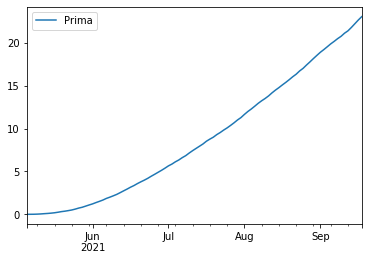

In [22]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [23]:
call_hist.iloc[-1]

Prima    23.064
Name: 2021-09-17 00:00:00, dtype: float64

In [24]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(22.052934232981553, 24.07583367356224)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [25]:
opt_valuar['JSON']['lastPrice']

3.25

## 3. Valuación de una opción up and in

### 3.1 Modelo normal de rendimientos

In [26]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.006/360
mu, sigma, r

(0.0013176508099668406, 0.017983725313409405, 1.6666666666666667e-05)

## Valuación opción call up-and-in

In [27]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(280.0, 246.33)

In [28]:
# Definir barrera

def opciones_barrera(s, k, mu, sigma, expires, bu = 0, bd = 0, n_sim = 10000):
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')

    ndays = len(dates)

    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+mu,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    
# 'CALL'- down-and-out
# 'PUT'- up-and-out 

    # Calcular la prima de una opción Europea
    call = pd.DataFrame({'Call':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0)
                         .mean(axis=1)},index=dates)
    put = pd.DataFrame({'Put':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0)
                     .mean(axis=1)},index=dates)
    
    # CALL OPTIONS
    
#     I = (sim_closes > bu).cumsum(axis=0) > 0
#     callui = pd.DataFrame({'Call up-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                            .mean(axis=1)},index=dates)

#     I = (sim_closes > bu).cumsum(axis=0) == 0
#     calluo = pd.DataFrame({'Call up-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                        .mean(axis=1)},index=dates)
    
#     I = (sim_closes < bd).cumsum(axis=0) > 0
#     calldi = pd.DataFrame({'Call down-and-in':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
#                        .mean(axis=1)},index=dates)    
    
    I = (sim_closes < bd).cumsum(axis=0) == 0
    calldo = pd.DataFrame({'Call down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)
    
    
       # PUT OPTIONS 
        
#     I = (sim_closes > bu).cumsum(axis=0) > 0
#     putui = pd.DataFrame({'Put up-and-in':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
#                            .mean(axis=1)},index=dates)

    I = (sim_closes > bu).cumsum(axis=0) == 0
    putuo = pd.DataFrame({'Put up-and-out':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    
#     I = (sim_closes < bd).cumsum(axis=0) > 0
#     putdi = pd.DataFrame({'Put down-and-in':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
#                        .mean(axis=1)},index=dates)    
    
#     I = (sim_closes < bd).cumsum(axis=0) == 0
#     putdo = pd.DataFrame({'Put down-and-out':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
#                        .mean(axis=1)},index=dates)
      
        
    # Graficar el resultado de las dos primas previamente valuadas
    ax = calldo.plot();
    call.plot(ax=ax);
    
    ax = putuo.plot();
    put.plot(ax=ax);

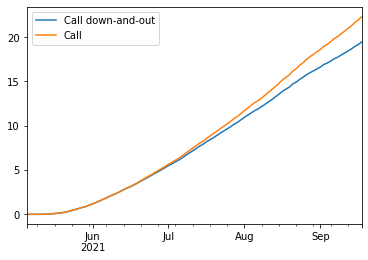

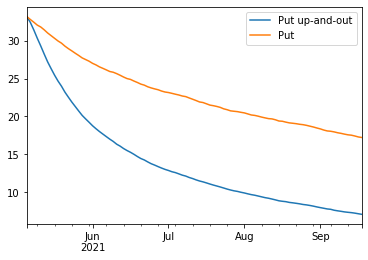

In [29]:
s = closes_msft.iloc[-1]
k = opt_valuar.Strike
mu = ret_msft.mean()
sigma = ret_msft.std()
expires = opt_valuar.Expiry
bu = 260
bd = 230
opciones_barrera(s, k, mu, sigma, expires, bu=bu, bd=bd)

En este primer ejemplo se puede apreciar que debido a que el strike price es menor al precio actual, en el caso del Call el precio de la prima considera el crecimiento, mientras que el caso del put tiene un valor intrínseco, haciendo la prima de este último mucho más alta. Como se puede observar en este ejercicio, adquirir un activo que se encuentra at the market es demasiado costoso y a largo plazo lo esperado es que baje de valor por la probabilidad de tocar la barrera de knock-out. 

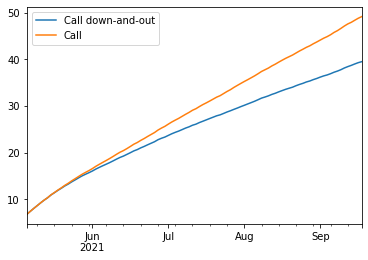

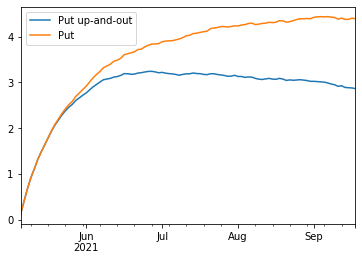

In [30]:
s = closes_msft.iloc[-1]
k = 240
mu = ret_msft.mean()
sigma = ret_msft.std()
expires = opt_valuar.Expiry
bu = 260
bd = 230
opciones_barrera(s, k, mu, sigma, expires, bu=bu, bd=bd)

Caso inverso en el segundo ejemplo, si cambiamos el strike price a 240 (menor que el precio actual) el Call tendría un valor intrínseco, por lo cual sería mucho más caro que uno out of the market. Y en este caso el put es considerablemente más accesible que el Call.

Un ejemplo para el primer caso en el que se necesita hacer uso de un Call y la opción barrera sería si se quiere comprar acciones de MSFT, pero se desea reducir el precio de la prima. De igual forma, el segundo escenario sería utilizado cuando se desea adquirir una opción para vender activos de la empresa al precio establecido, pero pagando una prima menor. 

## Respuesta Andrés

In [31]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_msft = closes.loc[:,'MSFT']
closes_msft

Date
2017-01-03     58.538
2017-01-04     58.276
2017-01-05     58.276
2017-01-06     58.782
2017-01-09     58.595
               ...   
2021-04-29    252.510
2021-04-30    252.180
2021-05-03    251.860
2021-05-04    247.790
2021-05-05    246.470
Name: MSFT, Length: 1092, dtype: float64

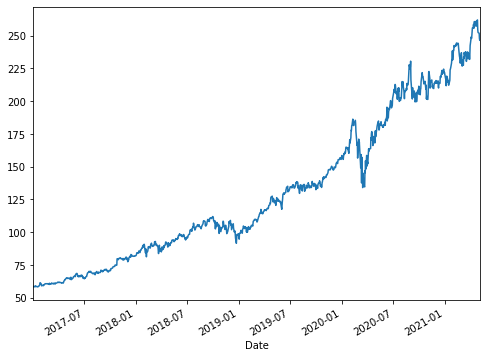

In [32]:
closes_msft.plot(figsize=(8,6));

246.47000122070312

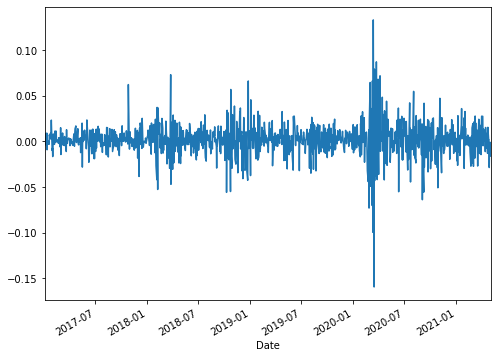

In [33]:
ret_msft = calc_daily_ret(closes_msft)
ret_msft.plot(figsize=(8,6))
closes_msft[-1]

In [34]:
pd.set_option('display.max_rows', 10)

msft = web.YahooOptions('MSFT')
msft_opt = msft.get_all_data().reset_index()
msft_opt.set_index('Expiry').sort_index()#.head(1000)

,Strike,Type,Symbol,...,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,
2021-05-07,212.5,put,MSFT210507P00212500,...,2021-05-05 23:59:51,2021-05-05 16:18:42,"{'contractSymbol': 'MSFT210507P00212500', 'str..."
2021-05-07,310.0,call,MSFT210507C00310000,...,2021-05-05 23:59:51,2021-05-03 18:19:38,"{'contractSymbol': 'MSFT210507C00310000', 'str..."
2021-05-07,310.0,put,MSFT210507P00310000,...,2021-05-05 23:59:51,2021-05-04 18:22:27,"{'contractSymbol': 'MSFT210507P00310000', 'str..."
2021-05-07,235.0,call,MSFT210507C00235000,...,2021-05-05 23:59:51,2021-05-05 19:21:09,"{'contractSymbol': 'MSFT210507C00235000', 'str..."
2021-05-07,235.0,put,MSFT210507P00235000,...,2021-05-05 23:59:51,2021-05-05 19:41:51,"{'contractSymbol': 'MSFT210507P00235000', 'str..."
...,...,...,...,...,...,...,...
2023-06-16,120.0,put,MSFT230616P00120000,...,2021-05-05 23:59:51,2021-04-21 14:36:50,"{'contractSymbol': 'MSFT230616P00120000', 'str..."
2023-06-16,295.0,call,MSFT230616C00295000,...,2021-05-05 23:59:51,2021-05-05 17:11:28,"{'contractSymbol': 'MSFT230616C00295000', 'str..."
2023-06-16,295.0,put,MSFT230616P00295000,...,2021-05-05 23:59:51,2021-05-03 13:39:26,"{'contractSymbol': 'MSFT230616P00295000', 'str..."


Esta tabla nos dice bastante pero para tener una una visualización más clara de com se presenta el strike price en los diferentes tipos de contrato tomando como día de "Expiry" el 17 de Septiembre.

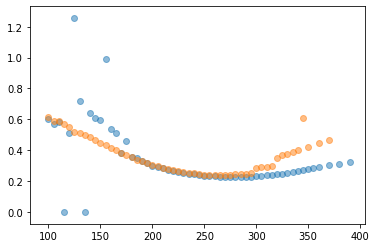

In [35]:
strike_call_msft = msft_opt['Strike'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'call')]
option_call_msft = msft_opt['IV'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'call')]
strike_put_msft = msft_opt['Strike'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'put')]
option_put_msft = msft_opt['IV'][(msft_opt['Expiry'] == '2021-09-17') & (msft_opt['Type'] == 'put')]


plt.scatter(strike_call_msft, option_call_msft, alpha = 0.5);
plt.scatter(strike_put_msft, option_put_msft, alpha = 0.5);

Debido a que para esta estrategia se necesita un valor por encima del spot price, tomaremos 260 como el strike price de la opcion.

In [36]:
opt_deseada = msft_opt.loc[(msft_opt.Type=='call') & (msft_opt.Strike==260) & (msft_opt.Expiry=='2021-09-17')]
opt_deseada

,Strike,Expiry,Type,...,Quote_Time,Last_Trade_Date,JSON
1120,260.0,2021-09-17,call,...,2021-05-05 23:59:51,2021-05-05 19:42:09,"{'contractSymbol': 'MSFT210917C00260000', 'str..."


In [37]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            260
Expiry                                            2021-09-17 00:00:00
Type                                                             call
Symbol                                            MSFT210917C00260000
Last                                                             8.07
                                          ...                        
Underlying                                                       MSFT
Underlying_Price                                                  246
Quote_Time                                        2021-05-05 23:59:51
Last_Trade_Date                                   2021-05-05 19:42:09
JSON                {'contractSymbol': 'MSFT210917C00260000', 'str...
Name: 1120, Length: 19, dtype: object

In [38]:
opt_valuar['JSON']

{'contractSymbol': 'MSFT210917C00260000',
 'strike': 260.0,
 'currency': 'USD',
 'lastPrice': 8.07,
 'change': -0.7300005,
 'percentChange': -8.29546,
 'volume': 87,
 'openInterest': 7536,
 'bid': 7.95,
 'ask': 8.35,
 'contractSize': 'REGULAR',
 'expiration': 1631836800,
 'lastTradeDate': 1620243729,
 'impliedVolatility': 0.22956092712402343,
 'inTheMoney': False}

## Modelo normal de los rendimientos

In [39]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.0006/360
mu, sigma, r

(0.0013176508099668406, 0.017983725313409405, 1.6666666666666665e-06)

   ## Simulacion de precios

In [40]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [41]:
from datetime import date
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes_hist = S0*np.exp(sim_ret.cumsum())

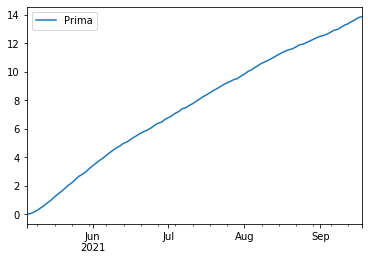

In [42]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [43]:
call.iloc[-1]

Prima    13.861
Name: 2021-09-17 00:00:00, dtype: float64

In [44]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(12.98084897550736, 14.741911617200167)


## Metodo del histograma

246.47000122070312

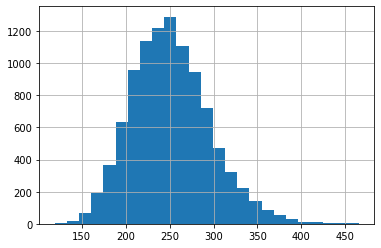

In [45]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_msft-mu+r, bins=10000)
prob = freq/np.sum(freq)

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_msft.iloc[-1]
ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[-1,:].hist(bins=25);
S0

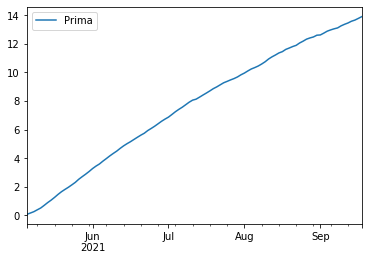

In [46]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [47]:
call_hist.iloc[-1]

Prima    13.906
Name: 2021-09-17 00:00:00, dtype: float64

In [48]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(13.030375941479265, 14.780924438670317)


In [49]:
opt_valuar['JSON']['lastPrice']

8.07

## Valuacion de metodo down and out

In [50]:
mu = ret_msft.mean()
sigma = ret_msft.std()
r = 0.006/360
mu, sigma, r

(0.0013176508099668406, 0.017983725313409405, 1.6666666666666667e-05)

In [51]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(260.0, 246.33)

In [52]:
# Definir barrera

def opciones_barrera(s, k, mu, sigma, expires, bu = 0, bd = 0, n_sim = 10000):
    
    today = pd.Timestamp(date.today())
    dates = pd.date_range(start = today, end = expiry, freq='B')
    ndays = len(dates)
    sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,n_sim)+r,index=dates)
    sim_closes = S0*np.exp(sim_ret.cumsum())
    
# 'CALL'- down-and-out
# 'PUT'- up-and-out 

    # Calcular la prima de una opción Europea
    call = pd.DataFrame({'Call Europea':np.exp(-r*ndays)*np.fmax(sim_closes - k, 0)
                         .mean(axis=1)},index=dates)
    put = pd.DataFrame({'Put Europea':np.exp(-r*ndays)*np.fmax(k - sim_closes, 0)
                     .mean(axis=1)},index=dates)

    # CALL OPTIONS 
    
    I = (sim_closes < bd).cumsum(axis=0) == 0
    calldo = pd.DataFrame({'Call down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - k, 0))
                       .mean(axis=1)},index=dates)   
    
       # PUT OPTIONS 
        
    I = (sim_closes > bu).cumsum(axis=0) == 0
    putuo = pd.DataFrame({'Put up-and-out':np.exp(-r*ndays)*(I * np.fmax(k - sim_closes, 0))
                       .mean(axis=1)},index=dates)
    
      
        
    # Graficar el resultado de las dos primas previamente valuadas
    ax = calldo.plot();
    call.plot(ax=ax);
    
    ax = putuo.plot();
    put.plot(ax=ax);

In [53]:
s = closes_msft.iloc[-1]
S0 = opt_valuar.Underlying_Price
expires = opt_valuar.Expiry
bu = 250
bd = 230
K,S0

(260.0, 246.33)

## Call down-and-out y Put up-and-out

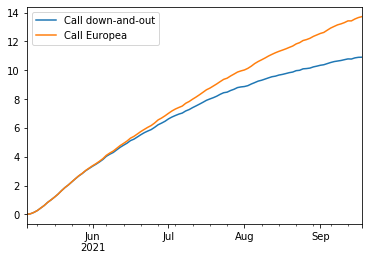

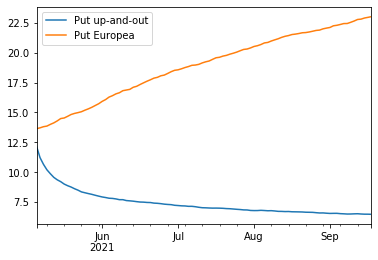

In [54]:
opciones_barrera(S0, K, mu, sigma, expires, bu=bu, bd=bd)

El comportamiento de estas opciones es peculiar debido a que el strike price esta por debajo al spot lo cual cumple con el objetivo de abaratar la prima. Quizas no sea el precio mas bajo de prima pero esto es considerando la posibilidad de emplear la opcion.

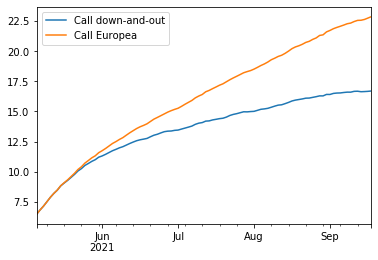

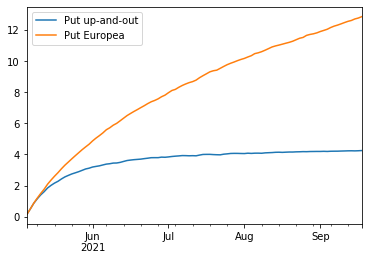

In [55]:
s = closes_msft.iloc[-1]
mu = ret_msft.mean()
sigma = ret_msft.std()
expires = opt_valuar.Expiry
bu = 250
bd = 230
opciones_barrera(s, 240, mu, sigma, expires, bu=bu, bd=bd)

En el caso de un valor strike menor cambia el precio de la prima de la opcion put volviendola mas cara.

La opcion barrera call seria muy buena alternativa al buscar comprar acciones de Microsoft porque si logra abaratar el precio de la prima. La opcion put facilitaria una ganancia en caso de necesitar vender dicha accion.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Z.
</footer>